# 2.- QAOA

### Setup

In [1]:
pip install qiskit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install qiskit-optimization

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.2/159.2 kB 1.7 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.8/610.8 kB 5.2 MB/s eta 0:00:005.5 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for docplex: filename=docplex-2.23.222-py3-none-any.whl size=662847 sha256=4d8650b0cc4c6088c7cf5289de564c16a9907434caeac40a5be78297f48983e0
  Stored in directory: /home/vruiz/.cache/pip/wheels/89/05/34/b6cc1d67bfdfea7f94383c36e770ca9e84bc34a22ab8b1e75f
Successfully built docplex
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pylatexenc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
token = "3d5d9f16fe638dd61f2fb72a4d457d66a2879d99254cbb251612ff82a2d82726a74d454cc2db1e2717262bb30ac63eeadecbf757fc2ada3c7f39f699ed818e06"

## 2.1- Using QAOA with Hamiltonians

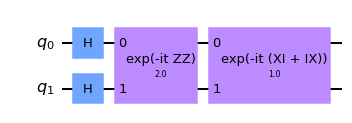

In [5]:
from qiskit.opflow import Z
from qiskit.algorithms import QAOA

H1 = Z^Z # Define Z_0Z_1
qaoa = QAOA()
circuit = qaoa.construct_circuit([1,2],H1)[0]
circuit.draw(output="mpl")

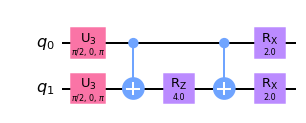

In [6]:
circuit.decompose().decompose().draw(output="mpl")

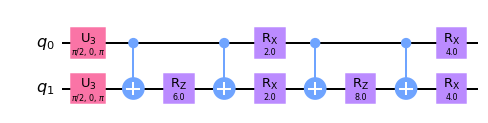

In [7]:
qaoa = QAOA(reps = 2) # p = 2
circuit = qaoa.construct_circuit([1,2,3,4],H1)[0]
circuit.decompose().decompose().draw(output="mpl")

In [8]:
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA

seed = 1234
algorithm_globals.random_seed = seed
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), 
                   seed_simulator=seed, seed_transpiler=seed, 
                   shots = 10)
qaoa = QAOA(optimizer = COBYLA(), quantum_instance=quantum_instance)
result = qaoa.compute_minimum_eigenvalue(H1)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 20,
    'eigenstate': {'01': 0.5477225575051661, '10': 0.8366600265340756},
    'eigenvalue': (-1+0j),
    'optimal_parameters': {   ParameterVectorElement(β[0]): 6.7647519845416655,
                              ParameterVectorElement(γ[0]): -0.847240391875931},
    'optimal_point': array([ 6.76475198, -0.84724039]),
    'optimal_value': -1.0,
    'optimizer_evals': None,
    'optimizer_time': 0.0966639518737793}


### Using Runtime

In [9]:
from qiskit import IBMQ

IBMQ.save_account(token)

provider = IBMQ.load_account()
program_id = "qaoa"

H1 = Z^Z
opt = COBYLA()
reps = 1
shots = 1024

runtime_inputs = {
    "operator": H1,
    "reps": reps,
    "optimizer": opt,
    "initial_point": [0,0],
    "use_swap_strategies": False
}

#options = {"backend_name": "ibmq_belem"}
options = {"backend_name": "ibmq_qasm_simulator"}

job = provider.runtime.run(program_id=program_id, 
      options=options, inputs=runtime_inputs)

In [10]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [11]:
result = job.result()
print("Optimizer time", result['optimizer_time'])
print("Optimal value", result['optimal_value'])
print("Optimal point", result['optimal_point'])
print("Optimal state", result['eigenstate'])

Optimizer time 0.9570298194885254
Optimal value -0.9941406250000001
Optimal point [1.16132467 0.81963987]
Optimal state {'01': 0.7022564079451322, '10': 0.7112379172963151, '11': 0.03125}


## 2.2- Solving QUBO problems with QAOA in Qiskit

In [12]:
from qiskit_optimization.problems import QuadraticProgram

qp = QuadraticProgram()
qp.binary_var('x')
qp.binary_var('y')
qp.binary_var('z')

qp.minimize(linear = {'y':-1}, quadratic = {('x','y'):2, ('z','y'):-4})
qp.linear_constraint(linear = {'x':1, 'y':2, 'z':3}, 
    sense ="<=", rhs = 5)

print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - y + [ 4 x*y - 8 y*z ]/2
Subject To
 c0: x + 2 y + 3 z <= 5

Bounds
 0 <= x <= 1
 0 <= y <= 1
 0 <= z <= 1

Binaries
 x y z
End



In [13]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import NumPyMinimumEigensolver
np_solver = NumPyMinimumEigensolver()
np_optimizer = MinimumEigenOptimizer(np_solver)
result = np_optimizer.solve(qp)
print(result)

fval=-5.0, x=0.0, y=1.0, z=1.0, status=SUCCESS


In [14]:
from qiskit import Aer
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), 
    shots = 1024)
qaoa = QAOA(optimizer = COBYLA(), 
    quantum_instance=quantum_instance, reps = 1)  
qaoa_optimizer = MinimumEigenOptimizer(qaoa)
result = qaoa_optimizer.solve(qp)
print(result)

fval=-5.0, x=0.0, y=1.0, z=1.0, status=SUCCESS


In [15]:
print('Variable order:', [var.name for var in result.variables])
for s in result.samples:
    print(s)

Variable order: ['x', 'y', 'z']
SolutionSample(x=array([0., 1., 1.]), fval=-5.0, probability=0.177734375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 0.]), fval=-1.0, probability=0.09863281250000001, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=0.0, probability=0.0625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=0.0, probability=0.08984375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=0.0, probability=0.150390625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=0.0, probability=0.18945312500000003, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=1.0, probability=0.0849609375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1.]), fval=-3.0, probability=0.146484375, status=<OptimizationResultStatus.INFEASIBLE: 2>)

In [16]:
print(result.min_eigen_solver_result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 27,
    'eigenstate': {   '000000': 0.16237976320958225,
                      '000001': 0.04419417382415922,
                      '000011': 0.1288470508005519,
                      '000100': 0.09375,
                      '000101': 0.04419417382415922,
                      '000110': 0.3365728004459065,
                      '000111': 0.08267972847076846,
                      '001000': 0.0625,
                      '001001': 0.09375,
                      '001010': 0.07654655446197431,
                      '001100': 0.06987712429686843,
                      '001101': 0.11692679333668567,
                      '001110': 0.08267972847076846,
                      '001111': 0.350780380010057,
                      '010000': 0.12103072956898178,
                      '010010': 0.1767766952966369,
                      '010100': 0.10364452469860624,
                      '010101': 0.08838834764831845,
                   

### Transforming the problem into the Ising model

In [17]:
from qiskit_optimization.converters import QuadraticProgramToQubo
qp_to_qubo = QuadraticProgramToQubo()
qubo = qp_to_qubo.convert(qp)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 80 x - 161 y - 240 z - 80 c0@int_slack@0 - 160 c0@int_slack@1
      - 160 c0@int_slack@2 + [ 16 x^2 + 68 x*y + 96 x*z + 32 x*c0@int_slack@0
      + 64 x*c0@int_slack@1 + 64 x*c0@int_slack@2 + 64 y^2 + 184 y*z
      + 64 y*c0@int_slack@0 + 128 y*c0@int_slack@1 + 128 y*c0@int_slack@2
      + 144 z^2 + 96 z*c0@int_slack@0 + 192 z*c0@int_slack@1
      + 192 z*c0@int_slack@2 + 16 c0@int_slack@0^2
      + 64 c0@int_slack@0*c0@int_slack@1 + 64 c0@int_slack@0*c0@int_slack@2
      + 64 c0@int_slack@1^2 + 128 c0@int_slack@1*c0@int_slack@2
      + 64 c0@int_slack@2^2 ]/2 + 200
Subject To

Bounds
 0 <= x <= 1
 0 <= y <= 1
 0 <= z <= 1
 0 <= c0@int_slack@0 <= 1
 0 <= c0@int_slack@1 <= 1
 0 <= c0@int_slack@2 <= 1

Binaries
 x y z c0@int_slack@0 c0@int_slack@1 c0@int_slack@2
End



In [18]:
H1, offset = qubo.to_ising()
print("The Hamiltonian is", H1)
print("The constant term is", offset)

The Hamiltonian is -7.0 * IIIIZI
- 4.5 * IIIIIZ
- 11.0 * IIIZII
- 4.0 * IIZIII
- 8.0 * IZIIII
- 8.0 * ZIIIII
+ 8.5 * IIIIZZ
+ 12.0 * IIIZIZ
+ 23.0 * IIIZZI
+ 4.0 * IIZIIZ
+ 8.0 * IIZIZI
+ 12.0 * IIZZII
+ 8.0 * IZIIIZ
+ 16.0 * IZIIZI
+ 24.0 * IZIZII
+ 8.0 * IZZIII
+ 8.0 * ZIIIIZ
+ 16.0 * ZIIIZI
+ 24.0 * ZIIZII
+ 8.0 * ZIZIII
+ 16.0 * ZZIIII
The constant term is 47.0


### Using Runtime

In [19]:
from qiskit_optimization.runtime import QAOAClient
from qiskit import IBMQ

provider = IBMQ.load_account()
qaoa_client = QAOAClient(provider=provider, 
                      #backend=provider.get_backend("ibm_manila"), reps=1)
                      backend=provider.get_backend("ibmq_qasm_simulator"), reps=1)

qaoa = MinimumEigenOptimizer(qaoa_client)
result = qaoa.solve(qp)
print(result)

ibmqfactory.load_account:WARNING:2022-10-20 13:14:32,577: Credentials are already in use. The existing account in the session will be replaced.


fval=-5.0, x=0.0, y=1.0, z=1.0, status=SUCCESS


In [20]:
print('Variable order:', [var.name for var in result.variables])
for s in result.samples:
    print(s)

Variable order: ['x', 'y', 'z']
SolutionSample(x=array([0., 1., 1.]), fval=-5.0, probability=0.1064453125, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 0.]), fval=-1.0, probability=0.1162109375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=0.0, probability=0.1220703125, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=0.0, probability=0.126953125, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=0.0, probability=0.1162109375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=0.0, probability=0.119140625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=1.0, probability=0.1474609375, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1.]), fval=-3.0, probability=0.1455078125, status=<OptimizationResultStatus.INFEASIBLE: 2>)


In [21]:
print(result.min_eigen_solver_result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 600,
    'eigenstate': {   '000000': 0.15309310892394862,
                      '000001': 0.06987712429686843,
                      '000011': 0.11267347735824966,
                      '000100': 0.19008632907181935,
                      '000101': 0.08838834764831845,
                      '000110': 0.13258252147247765,
                      '000111': 0.20009763241977652,
                      '001000': 0.10364452469860624,
                      '001001': 0.11692679333668567,
                      '001010': 0.08838834764831845,
                      '001011': 0.14986973510352247,
                      '001100': 0.1288470508005519,
                      '001101': 0.17399263633843817,
                      '001110': 0.14986973510352247,
                      '001111': 0.14320549046737,
                      '010000': 0.10364452469860624,
                      '010001': 0.09375,
                      '010010': 0.10364452469